In [13]:
import json
#time for 10 qubits
with open("/Users/qilimanjaro/Documents/TFM/project-master-jan/rl-zx/5_25_clifford_training/5q/time_depth.json") as f:
    time_5_stats = json.load(f)
    f.close()
with open("/Users/qilimanjaro/Documents/TFM/project-master-jan/rl-zx/5_25_clifford_training/10q/time_depth.json") as f:
    time_10_stats = json.load(f)
    f.close()
with open("/Users/qilimanjaro/Documents/TFM/project-master-jan/rl-zx/5_25_clifford_training/20q/time_depth.json") as f:
    time_20_stats = json.load(f)
    f.close()

In [95]:
len(time_10_stats["full_time"])

15

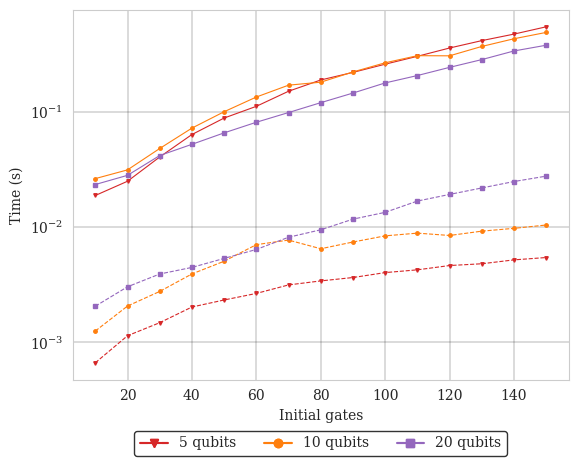

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.legend_handler as lh

sns.set_style("whitegrid")
plt.rcParams['grid.linewidth'] = 0.2

plt.rcParams['font.family'] = 'serif'
plt.grid(True, color='black')

plt.plot(range(10,160,10), time_5_stats["full_time"],c = "#d62728", marker="v",markersize=2.5, linestyle="dashed",linewidth=0.8)
plt.plot(range(10,160,10), time_5_stats["rl_time"],c = "#d62728", marker="v",markersize=2.5, linestyle="solid",linewidth=0.8, label = "5 qubits")

plt.plot(range(10,160,10), time_10_stats["full_time"], c="#ff7f0e", marker="o",markersize=2.5, linestyle="dashed",linewidth=0.8)
plt.plot(range(10,160,10), time_10_stats["rl_time"], c = "#ff7f0e", marker="o",markersize=2.5, linestyle="solid",linewidth=0.8, label = "10 qubits")

plt.plot(range(10,160,10), time_20_stats["full_time"],c = "#9467bd", marker="s",markersize=2.5, linestyle="dashed",linewidth=0.8)
plt.plot(range(10,160,10), time_20_stats["rl_time"],c="#9467bd", marker="s",markersize=2.5, linestyle="solid",linewidth=0.8, label= "20 qubits")
plt.yscale("log")
plt.ylabel("Time (s)")
plt.xlabel("Initial gates")
handler_map = {
    "5 qubits": lh.HandlerTuple(ndivide=None),
    "10 qubits": lh.HandlerTuple(ndivide=None),
    "20 qubits": lh.HandlerTuple(ndivide=None),
}

# Create a list of handles and labels for the legend.
handles = [
    (plt.Line2D([], [], color="#d62728", linestyle="dashed", marker="v"),
     plt.Line2D([], [], color="#d62728", linestyle="solid", marker="v")),
    (plt.Line2D([], [], color="#ff7f0e", linestyle="dashed", marker="o"),
     plt.Line2D([], [], color="#ff7f0e", linestyle="solid", marker="o")),
    (plt.Line2D([], [], color="#9467bd", linestyle="dashed", marker="s"),
     plt.Line2D([], [], color="#9467bd", linestyle="solid", marker="s")),
]
labels = ["5 qubits", "10 qubits", "20 qubits"]

# Add the legend with the custom handler map and handles.
plt.legend(handles, labels, handler_map=handler_map, loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=3, edgecolor="black")
plt.show()


In [ ]:
import pyzx as zx
import numpy as np

def basic_optimise(c):
    c1 = zx.basic_optimization(c.copy(), do_swaps=False).to_basic_gates()
    c2 = zx.basic_optimization(c.copy(), do_swaps=True).to_basic_gates()
    if c2.twoqubitcount() < c1.twoqubitcount(): return c2 # As this optimisation algorithm is targetted at reducting H-gates, we use the circuit with the smaller 2-qubit gate count here, either using SWAP rules or not.
    return c1

def clifford_simp(c):
    g = c.to_graph()
    zx.clifford_simp(g, quiet=True)
    c2 = zx.extract_circuit(g).to_basic_gates()
    return basic_optimise(c2)

def teleport_reduce(c):
    g = c.to_graph()
    zx.teleport_reduce(g)
    #zx.full_reduce(g, quiet=True)
    c2 = zx.Circuit.from_graph(g)
    return basic_optimise(c2)

def full_reduce_opt(c):
    g = c.to_graph()
    zx.simplify.full_reduce(g)
    c2 = zx.extract_simple(g).to_basic_gates()
    return basic_optimise(c2)

def gflow_opt(c):
    g = c.to_graph()
    zx.teleport_reduce(g)
    zx.to_graph_like(g)
    zx.simplify.greedy_simp(g)
    c2 = zx.extract_circuit(g).to_basic_gates()
    return basic_optimise(c2)

def flow_opt(c):
    g = c.to_graph()
    zx.teleport_reduce(g)
    zx.to_graph_like(g)
    zx.flow_2Q_simp(g)
    c2 = zx.extract_simple(g).to_basic_gates()
    return basic_optimise(c2)

In [ ]:
qubits,depth = 10,10

result_list, basic_result, full_list, cflow_list, gflow_list = [],[],[],[],[]
tqresult_list, tqbasic_result, tqfull_list, tqcflow_list, tqgflow_list = [],[],[],[],[]
initial_twoqubit = []
for _ in range(0,400, 10):
    list1,list2,list3,list4, list5 = [],[],[],[],[]
    twoq1,twoq2,twoq3,twoq4, twoq5 = [],[],[],[],[]
    initialtwoq = []
    for _ in range(40):
        
        g = zx.generate.cliffordT(qubits, depth, p_cnot=0.25,p_t=0.25, p_hsh=0.25, p_s=0.25 )
        c = zx.Circuit.from_graph(g.copy())
        cflow = flow_opt(c.copy())
       
        

        
        g_full = g.copy()
        zx.simplify.full_reduce(g_full)
        full_circuit = zx.extract_circuit(g_full.copy()).to_basic_gates()
        full_circuit_optimized = basic_optimise(full_circuit)

        circuit= zx.basic_optimization(c.split_phase_gates()).to_basic_gates()
        gflow = gflow_opt(c.copy())
        
        basic_dict = circuit.stats_dict()
        full_circuit_optimized_dict = full_circuit_optimized.stats_dict()
        cflow_circuit = cflow.stats_dict()
        gflow_circuit = gflow.stats_dict()
       
      
        list2.append(basic_dict["gates"])
        list3.append(full_circuit_optimized_dict["gates"])
        list4.append(cflow_circuit["gates"])
        list5.append(gflow_circuit["gates"])
     
        twoq2.append(basic_dict["twoqubit"])
        twoq3.append(full_circuit_optimized_dict["twoqubit"])
        twoq4.append(cflow_circuit["twoqubit"])
        twoq5.append(gflow_circuit["twoqubit"])
    
  
    basic_result.append(np.mean(list2))
    full_list.append(np.mean(list3))
    cflow_list.append(np.mean(list4))
    gflow_list.append(np.mean(list5))
    
    tqbasic_result.append(np.mean(twoq2))
    tqfull_list.append(np.mean(twoq3))
    tqcflow_list.append(np.mean(twoq4))
    initial_twoqubit.append(np.mean(initialtwoq))
    tqgflow_list.append(np.mean(twoq5))
    depth=depth+10

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
plt.rc("font", size=15)
plt.rcParams["grid.linewidth"] = 0.2
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["font.family"] = "serif"
plt.grid(True, color="black")
styles = ["-", "--", "-.", ":", "dashed"]
colors = ["#53257F", "#BC1B73", "#F8534A", "#FFA600"]
depth = np.arange(40) * 8 + 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(
    depth, basic_result, c="#0343DF", marker="s", markersize=3.5, linestyle="solid", linewidth=0.8, label="basic-opt"
)
ax1.plot(depth,full_list, c="#7E1E9C", marker="v", markersize=3.5, linestyle="--", linewidth=0.8, label="full-reduce+")
ax1.plot(depth, cflow_list, c="#F97306", marker="o", markersize=2.5, linestyle="--", linewidth=0.8, label="cflow-zx")
ax1.plot(depth, gflow_list, marker="x", markersize=2.5, linestyle="--", linewidth=0.8, label="gflow-zx")


ax1.fill_between(depth, depth, np.max(depth), where=(depth <= depth), color="red", alpha=0.1, interpolate=True)
ax1.fill_between(depth, depth, np.min(depth), where=(depth <= depth), color="green", alpha=0.1, interpolate=True)
ax1.set_xlabel("Initial gates")
ax1.set_xlim(10, 320)
ax1.set_ylim(10, 320)
ax1.set_title("(a)")
ax1.set_ylabel("Gates after optimization")
ax2.plot(
    depth * 0.25, tqcflow_list, c="#F97306", marker="o", markersize=2.5, linestyle="--", linewidth=0.8, label="rl-zx"
)
ax2.plot(
    depth * 0.25,
    tqfull_list,
    c="#7E1E9C",
    marker="v",
    markersize=3.5,
    linestyle="--",
    linewidth=0.8,
    label="full-reduce",
)
ax2.plot(
    depth * 0.25,
    tqbasic_result,
    c="#0343DF",
    marker="s",
    markersize=3.5,
    linestyle="solid",
    linewidth=0.8,
    label="basic-opt",
)
ax2.plot(
    depth * 0.25,
    tqgflow_list,
    marker="s",
    markersize=3.5,
    linestyle="solid",
    linewidth=0.8,
    label="gflow-zx",
)
ax2.fill_between(
    0.25 * depth,
    0.25 * depth,
    np.max(depth),
    where=(0.25 * depth <= 0.25 * depth),
    color="red",
    alpha=0.1,
    interpolate=True,
)
ax2.fill_between(
    0.25 * depth,
    0.25 * depth,
    np.min(0.25 * depth),
    where=(0.25 * depth <= 0.25 * depth),
    color="green",
    alpha=0.1,
    interpolate=True,
)

ax2.set_xlabel("Initial 2-qubit gates")
ax2.set_xlim(3,80)
ax2.set_ylim(3, 220)
ax2.set_title("(b)")
ax2.set_ylabel("2-qubit Gates after optimization")
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), edgecolor="black", ncol=4)
# fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=4, edgecolor="black")
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig("10-qubitsresults.pdf", format="pdf", dpi=1200, bbox_inches="tight")